<a href="https://colab.research.google.com/github/brijw/DataAnalytics/blob/main/kmeans_corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import numpy as np
import re
import plotly.graph_objects as go
import pandas as pd
import nltk
import textblob
import plotly.express as px
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from nltk.sentiment.vader import SentimentIntensityAnalyzer as vad
import plotly
#plotly.offline.init_notebook_mode (connected = True)

from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/MSC/Analytics/Comments.xlsx')
#docs = data['Comment']

In [55]:
data.head()

,comment_id,Comment
0,5,djfjkdfjkjkffdk edited
1,41,Faith has exhibited enthusiasm in taking on th...
2,49,He now has now understood the structure of gra...
3,50,The Intern was oriented on ICT setup and Infra...
4,52,The student was oriented on the organization s...


In [56]:
data.shape

(3874, 2)

In [57]:
data.describe()

,comment_id
count,3874.000000
mean,3621.646618
std,1969.848443
min,5.000000
25%,2022.250000
50%,3358.000000
75%,5129.500000
max,7942.000000


In [58]:
data['Comment']=data['Comment'].apply(str)
# Proprocessing the data
data['Comment']=data['Comment'].str.lower()
# Code to remove the Hashtags from the text
data['Comment']=data['Comment'].apply(lambda x:re.sub(r'\B#\S+','',x))
# Code to remove the links from the text
data['Comment']=data['Comment'].apply(lambda x:re.sub(r"http\S+", "", x))
# Code to remove the Special characters from the text 
data['Comment']=data['Comment'].apply(lambda x:' '.join(re.findall(r'\w+', x)))
# Code to substitute the multiple spaces with single spaces
data['Comment']=data['Comment'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
# Code to remove all the single characters in the text
data['Comment']=data['Comment'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Remove the twitter handlers
data['Comment']=data['Comment'].apply(lambda x:re.sub('@[^\s]+','',x))

In [59]:
data=data[['Comment']]

In [60]:
data.head()

,Comment
0,djfjkdfjkjkffdk edited
1,faith has exhibited enthusiasm in taking on th...
2,he now has now understood the structure of gra...
3,the intern was oriented on ict setup and infra...
4,the student was oriented on the organization s...


In [61]:
data.to_csv(r'/content/drive/MyDrive/Colab Notebooks/MSC/Analytics/corpustext_cleaned.csv', index = False)

In [62]:
# Making the copy of th data
km=data.copy()

def rem_stopwords_tokenize(data,name):
      
    def getting(sen):
        example_sent = sen

        stop_words = set(stopwords.words('english')) 

        word_tokens = word_tokenize(example_sent) 

        filtered_sentence = [w for w in word_tokens if not w in stop_words] 

        filtered_sentence = [] 

        for w in word_tokens: 
            if w not in stop_words: 
                filtered_sentence.append(w.lower()) 
        return filtered_sentence
    x=[]
    for i in data[name].values:
        x.append(getting(i))
    data[name]=x

# Making a function to lemmatize all the words
lemmatizer = WordNetLemmatizer() 
def lemmatize_all(data,name):
    arr=data[name]
    a=[]
    for i in arr:
        b=[]
        for j in i:
            x=lemmatizer.lemmatize(j,pos='a')
            x=lemmatizer.lemmatize(x)
            b.append(x)
        a.append(b)
    data[name]=a

In [63]:
km['Comment']=km['Comment'].apply(str)

In [64]:
#km.to_csv(r'/content/drive/MyDrive/Colab Notebooks/MSC/Analytics/corpuscollection.csv', index = False)

In [65]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

rem_stopwords_tokenize(km,'Comment')
lemmatize_all(km,'Comment')

km['Comment']=km['Comment'].apply(lambda x:' '.join([i+' ' for i in x]))
# Removing double spaces if created
km['Comment']=km['Comment'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Converting the text into vectors using TdidfVectorizer

In [66]:
# Tfidf Vectorizer
tf=TfidfVectorizer()
# Fit transform the data
X=tf.fit_transform(km['Comment'].values)

In [67]:
#print(X)

In [68]:
for i, feature in enumerate(tf.get_feature_names_out()[:10]):
    print(i, feature)

0 000
1 04
2 10
3 100
4 1400
5 1st
6 20
7 2010
8 2012
9 2019


In [69]:
def find_optimal_clusters(data, max_k):
    iters = range(4, max_k+1, 4)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=64, batch_size=128, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

Fit 4 clusters
Fit 8 clusters
Fit 12 clusters
Fit 16 clusters
Fit 20 clusters


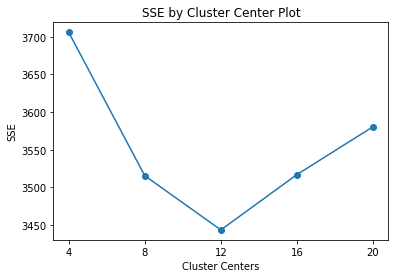

In [70]:
find_optimal_clusters(X, 20)

In [71]:
clusters = MiniBatchKMeans(n_clusters=5, init_size=64, batch_size=256, random_state=20).fit_predict(X)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



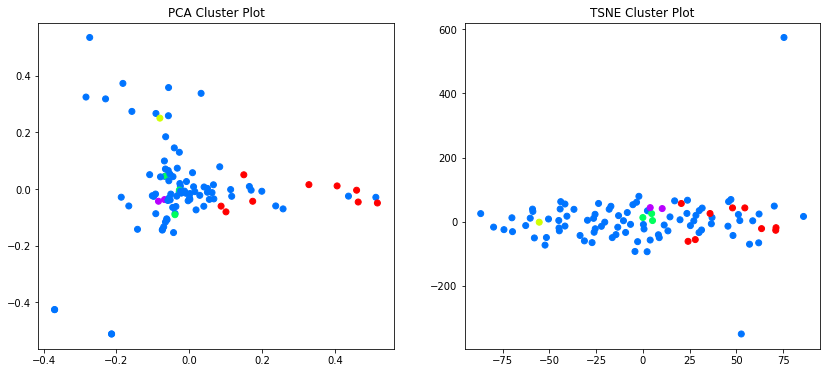

In [72]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)+1
    max_items = np.random.choice(range(data.shape[0]), size=100, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=100, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(X, clusters)

In [73]:
clusters = MiniBatchKMeans(n_clusters=5, init_size=128, batch_size=256, random_state=20).fit_predict(X)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



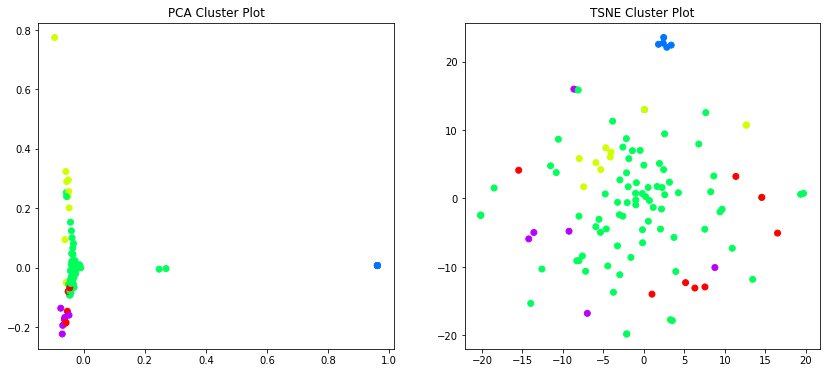

In [74]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)+1
    max_items = np.random.choice(range(data.shape[0]), size=300, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=110, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(X, clusters)

In [75]:
# Function  to get the top keywords
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(X, clusters, tf.get_feature_names(), 10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.




Cluster 0
stratcom,supposed,successfully,mobile,skill,managed,app,end,challenge,internship

Cluster 1
record,week,time,team,coworkers,working,progress,relationship,work,good

Cluster 2
great,server,system,done,time,student,task,week,well,work

Cluster 3
system,development,weektasks,networking,installation,recording,technically,hand,task,progressive

Cluster 4
app,device,time,without,well,weekmain,weektasks,successfully,task,completed


In [76]:
# Making a classes column and putting the values there
km['Classes']=clusters
# Having a look at the data
km[km['Classes']==4].head()

,Comment,Classes
5,activity well completed,4
14,activity took time completed completed satisfa...,4
19,noted task completed,4
101,completed satisfaction,4
111,completed satisfaction,4


In [77]:
km[km['Classes']==0].head()

,Comment,Classes
388,joshua facedfew challenge coding beginning int...,0
393,stom managed catch despite facingfew challenge,0
394,kenneth managed complete weekmain task setting...,0
395,despite afew challenge especially programming ...,0
402,francis started internship also managed set de...,0


In [78]:
km[km['Classes']==1].head()

,Comment,Classes
7,studentweekly progress justifiably good charac...,1
22,good knowledge whole process installation,1
28,good attitude resilience isgood start,1
30,good progressexpect student work together period,1
31,good time keeper much interest network,1


In [79]:
km[km['Classes']==2].head()

,Comment,Classes
0,djfjkdfjkjkffdk edited,2
1,faith exhibited enthusiasm taking project hand...,2
2,understood structure grail different component...,2
3,intern oriented ict setup infrastructure sorot...,2
4,student oriented organization structure develo...,2


In [80]:
km[km['Classes']==3].tail()

,Comment,Classes
3392,progressive,3
3742,progressive,3
3772,progressive,3
3773,progressive,3
3775,progressive,3


In [81]:
# km['Classes'].replace({0:'Very Poor',1:'Poor',2:'Good',3:'Neutral',4:'Excellent'},inplace=True)

km['Classes'].replace({0:'Poor',1:'Good',2:'Very Poor',3:'Neutral',4:'Excellent'},inplace=True)

In [82]:
kmeans_vector=tf.fit_transform(km['Comment'].values)
pca3 = PCA(n_components=3).fit_transform(kmeans_vector.todense())
px.scatter_3d(x=pca3[:,0],y=pca3[:,1],z=pca3[:,2],color=km['Classes'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



In [83]:
km.head()

,Comment,Classes
0,djfjkdfjkjkffdk edited,Very Poor
1,faith exhibited enthusiasm taking project hand...,Very Poor
2,understood structure grail different component...,Very Poor
3,intern oriented ict setup infrastructure sorot...,Very Poor
4,student oriented organization structure develo...,Very Poor


In [85]:
#km.to_csv(r'/content/drive/MyDrive/Colab Notebooks/MSC/Analytics/corpus.csv', index = False)